### Notebook for the integration using ```scVI``` and clustering evaluation with ```SCCAF``` for Healthy PBMCs

- **Objective**: Integration of healthy and TB PBMCs from [Cai 2020](https://pubmed.ncbi.nlm.nih.gov/32114394/) and [Yoshida 2021](https://www.nature.com/articles/s41591-021-01329-2). 
- **Developed by**: Mairi McClean
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- **v230425**


### Import required modules

In [2]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import ipywidgets as ipw

import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
absl                NA
anyio               NA
appnope             0.1.3
arrow               1.2.3
asttokens           NA
attr                23.1.0
babel               2.12.1
backcall            0.2.0
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  3.1.0
chex                0.1.7
colorama            0.4.6
comm                0.1.3
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
docrep              0.3.2
executing           1.2.0
fastjsonschema      NA
flax                0.6.1
fqdn                NA
fsspec              2023.4.0
gmpy2               2.1.2
h5py                3.8.0
idna                3.4
igraph              0.10.4
importlib_resources NA
ipykernel           6.22.0
ipython_genutils    0.2.0
ipywidgets          8.0.6
isodu

### Read in datasets for integration


- Read in _Cai Y et al 2020_

In [5]:
caiy2020 = sc.read_h5ad('/Users/mairi.mcclean/example_data_lake/processed_files/final_qc_mm230627/human/cai_2020/CaiY2020_PBMC_mm230627.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 73146 × 36039
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets'
    var: 'gene_id', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'status_colors'
    layers: 'counts', 'sqrt_norm'

In [6]:
caiy2020.obs['status'].value_counts()

status
active_TB    33104
Healthy      22049
latent_TB    17993
Name: count, dtype: int64

- Read in _Yoshida et al 2021_

In [10]:
adata_yoshida = sc.read_h5ad('/Users/mairi.mcclean/Desktop/meyer_nikolic_covid_pbmc_raw.h5ad')
adata_yoshida

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

In [11]:
adata_yoshida.obs['COVID_status'].value_counts()

COVID_status
Healthy          173684
COVID-19         151312
Post-COVID-19     97224
Name: count, dtype: int64

- Subset healthy Yoshida data 

In [12]:
yoshida_healthy = adata_yoshida[adata_yoshida.obs['COVID_status'].isin(['Healthy'])]
yoshida_healthy

View of AnnData object with n_obs × n_vars = 173684 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

In [13]:
yoshida_healthy.obs['COVID_status'].value_counts()

COVID_status
Healthy    173684
Name: count, dtype: int64

In [14]:
yoshida_healthy.obs

orig.ident   
index                                                                                   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  CV001_KM10202384-CV001_KM10202394  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  CV001_KM10202384-CV001_KM10202394   
...                                                                               ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1    CV001_KM9166642-CV001_KM9166650   

                                                    nCount_RNA  nFeature_RNA   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5493.0          1767  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      4868.0          1577   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      3178.0          1257   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      4745.0          1477   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1902.0           954   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1      3513.0          1297   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1      1888.0          1296   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      1798.0           814   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      4407.0          1351   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1      2676.0          1297   

                                                    nCount_ADT  nFeature_ADT   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5297.0           184  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      2169.0           165   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      1330.0           163   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      1255.0           161   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1711.0           166   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1       513.0           137   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1       631.0           145   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      2227.0           169   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      1014.0           153   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1       779.0           138   

                                                     Age_group      BMI   
index                                                                     
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Adult  Unknown  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...       Adult  Unknown   
...                                                        ...      ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1       Child     18.2   
CV001_KM91

In [15]:
yoshida_healthy.obs['patient_id'].value_counts()

patient_id
NP18    9799
NP13    8945
AN13    8244
NP23    8038
NP24    7376
AN12    7219
AN7     7105
NP19    7050
NP28    6894
NP17    6377
NP39    6115
AN2     5973
NP44    5906
NP36    5891
NP22    5535
NP27    5300
NP31    5029
NP21    4833
NP37    4654
AN6     4296
AN9     4150
AN5     3943
NP30    3916
NP41    3898
NP32    3778
NP15    3701
NP26    3539
NP20    3374
NP38    3218
AN14    2260
NP16    1851
AN11    1847
NP35    1674
AN3     1041
AN1      915
Name: count, dtype: int64

In [16]:
yoshida_healthy.obs['sample_id'].value_counts()

sample_id
NP18    9799
NP13    8945
AN13    8244
NP23    8038
NP24    7376
AN12    7219
AN7     7105
NP19    7050
NP28    6894
NP17    6377
NP39    6115
AN2     5973
NP44    5906
NP36    5891
NP22    5535
NP27    5300
NP31    5029
NP21    4833
NP37    4654
AN6     4296
AN9     4150
AN5     3943
NP30    3916
NP41    3898
NP32    3778
NP15    3701
NP26    3539
NP20    3374
NP38    3218
AN14    2260
NP16    1851
AN11    1847
NP35    1674
AN3     1041
AN1      915
Name: count, dtype: int64

- Rename shared column headers 
> so that subsequent object concatenation is easier

In [17]:
yoshida_healthy.obs.rename(columns={"patient_id": "donor"}, inplace=True)
yoshida_healthy.obs.rename(columns={"COVID_status": "status"}, inplace=True)
yoshida_healthy.obs.rename(columns={"Sex": "gender"}, inplace=True)
yoshida_healthy.obs.rename(columns={"Age_group": "age"}, inplace=True)
yoshida_healthy.obs['tissue'] = 'PBMC'
yoshida_healthy.obs

orig.ident   
index                                                                                   
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...  CV001_KM10202384-CV001_KM10202394  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...  CV001_KM10202384-CV001_KM10202394   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...  CV001_KM10202384-CV001_KM10202394   
...                                                                               ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1    CV001_KM9166642-CV001_KM9166650   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1    CV001_KM9166642-CV001_KM9166650   

                                                    nCount_RNA  nFeature_RNA   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5493.0          1767  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      4868.0          1577   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      3178.0          1257   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      4745.0          1477   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1902.0           954   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1      3513.0          1297   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1      1888.0          1296   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      1798.0           814   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      4407.0          1351   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1      2676.0          1297   

                                                    nCount_ADT  nFeature_ADT   
index                                                                          
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...      5297.0           184  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...      2169.0           165   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...      1330.0           163   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...      1255.0           161   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...      1711.0           166   
...                                                        ...           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1       513.0           137   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1       631.0           145   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1      2227.0           169   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTAG-1      1014.0           153   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGCT-1       779.0           138   

                                                           age      BMI   
index                                                                     
CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAG...       Adult  Unknown  \
CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTC...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAG...       Adult  Unknown   
CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGC...       Adult  Unknown   
...                                                        ...      ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATCG-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGTA-1  Adolescent     24.7   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCCC-1       Child     18.2   
CV001_KM91

- Merge _Cai_ and _Yoshida_ data

In [23]:
adata_combined = caiy2020.concatenate(yoshida_healthy, batch_key = 'dataset', batch_categories = ['caiy2020', 'yoshida2021'], join = 'inner')
adata_combined

AnnData object with n_obs × n_vars = 246830 × 18966
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'doublet_scores', 'predicted_doublets', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'BMI', 'COVID_severity', 'Ethnicity', 'Group', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'dataset'
    var: 'gene_id-caiy2020', 'n_cells-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'hb-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021'

- Remove unrequired columns

In [25]:
adata_combined.obs = adata_combined.obs.drop(columns=['age', 'gender', 'data_type', 'centre', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'S_score'])

In [26]:
adata_combined.obs = adata_combined.obs.drop(columns= ['version', 'batch', 'Ethnicity', 'Group', 'sequencing_library', 'Protein_modality_weight', 
'individual', 'sample', 'COVID_severity', 'Smoker', 'BMI', 'nFeature_ADT', 'nCount_ADT', 'nFeature_RNA', 'nCount_RNA', 'orig.ident', 
'G2M_score', 'predicted_doublets', 'total_counts_mt', 'total_counts', 'n_genes_by_counts', 'n_genes'])

In [27]:
adata_combined.obs['study'] = adata_combined.obs['study'].cat.add_categories("Yoshida_2021").fillna("Yoshida_2021")

In [28]:
adata_combined.obs

study tissue   
AAACCTGAGAACAATC-acTB3-caiy2020                        CaiY_2021   PBMC  \
AAACCTGAGAAGGTGA-acTB3-caiy2020                        CaiY_2021   PBMC   
AAACCTGAGATCTGCT-acTB3-caiy2020                        CaiY_2021   PBMC   
AAACCTGAGCACAGGT-acTB3-caiy2020                        CaiY_2021   PBMC   
AAACCTGAGCGTGAAC-acTB3-caiy2020                        CaiY_2021   PBMC   
...                                                          ...    ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATC...  Yoshida_2021   PBMC   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGT...  Yoshida_2021   PBMC   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCC...  Yoshida_2021   PBMC   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTA...  Yoshida_2021   PBMC   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGC...  Yoshida_2021   PBMC   

                                                           donor     status   
AAACCTGAGAACAATC-acTB3-caiy2020                     SAMN14048025  active_TB  \
AAACCTGAGAAGGTGA-acTB3-caiy2020                     SAMN14048025  active_TB   
AAACCTGAGATCTGCT-acTB3-caiy2020                     SAMN14048025  active_TB   
AAACCTGAGCACAGGT-acTB3-caiy2020                     SAMN14048025  active_TB   
AAACCTGAGCGTGAAC-acTB3-caiy2020                     SAMN14048025  active_TB   
...                                                          ...        ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATC...          NP32    Healthy   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGT...          NP32    Healthy   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCC...          NP31    Healthy   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTA...          NP31    Healthy   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGC...          NP32    Healthy   

                                                    total_counts_hb   
AAACCTGAGAACAATC-acTB3-caiy2020                                 1.0  \
AAACCTGAGAAGGTGA-acTB3-caiy2020                                 0.0   
AAACCTGAGATCTGCT-acTB3-caiy2020                                 0.0   
AAACCTGAGCACAGGT-acTB3-caiy2020                               748.0   
AAACCTGAGCGTGAAC-acTB3-caiy2020                                 0.0   
...                                                             ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATC...              NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGT...              NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCC...              NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTA...              NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGC...              NaN   

                                                    pct_counts_hb   
AAACCTGAGAACAATC-acTB3-caiy2020                          0.017749  \
AAACCTGAGAAGGTGA-acTB3-caiy2020                          0.000000   
AAACCTGAGATCTGCT-acTB3-caiy2020                          0.000000   
AAACCTGAGCACAGGT-acTB3-caiy2020                         18.732782   
AAACCTGAGCGTGAAC-acTB3-caiy2020                          0.000000   
...                                                           ...   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTCGCATC...            NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCAGTGTAAGT...            NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCATGTCC...            NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCGAGGTA...            NaN   
CV001_KM9166642-CV001_KM9166650_TTTGTCATCTGCTGC...            NaN   

                                                    doublet_scores   
AAACCTGAGAACAATC-acTB3-caiy2020                           0.026545  \
AAACCTGAGAAGGTGA-acTB3-caiy2020                           0.060221   
AAACCTGAGATCTGCT-acTB3-caiy2020                           0.078989   
AAACCTGAGCACAGGT-acTB3-caiy2020                           0.069242   
AAACCTGAGCGTGAAC-acTB3-caiy2020                           0.024034   
...                                                            ...   
CV001_KM9166642-CV001_KM9166650_TTTGT

### Harmonized dataset labels

- Check 'tissue' label is unanimous in both datasets

In [29]:
adata_combined.obs['tissue'].value_counts()

tissue
PBMC    246830
Name: count, dtype: int64

In [30]:
# Check donor
adata_combined.obs['donor'].value_counts()

donor
SAMN14048023    11521
SAMN14048019    11275
SAMN14048025    11174
SAMN14048020    10774
SAMN14048024    10409
SAMN14048022     9846
NP18             9799
NP13             8945
AN13             8244
SAMN14048021     8147
NP23             8038
NP24             7376
AN12             7219
AN7              7105
NP19             7050
NP28             6894
NP17             6377
NP39             6115
AN2              5973
NP44             5906
NP36             5891
NP22             5535
NP27             5300
NP31             5029
NP21             4833
NP37             4654
AN6              4296
AN9              4150
AN5              3943
NP30             3916
NP41             3898
NP32             3778
NP15             3701
NP26             3539
NP20             3374
NP38             3218
AN14             2260
NP16             1851
AN11             1847
NP35             1674
AN3              1041
AN1               915
Name: count, dtype: int64

### Calculate HVGs

In [31]:
adata_raw = adata_combined.copy()
adata_combined.layers['counts'] = adata_combined.X.copy()

In [32]:
sc.pp.highly_variable_genes(adata_combined,
    flavor = "seurat_v3", 
    n_top_genes = 3000, 
    layer = "counts", 
    batch_key = "donor", 
    subset = True
)

adata_combined

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 246830 × 3000
    obs: 'study', 'tissue', 'donor', 'status', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'sample_id', 'dataset'
    var: 'gene_id-caiy2020', 'n_cells-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'hb-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

#### Remove unrequired variables prior to model run
- In order to improve size of notebook

In [33]:
del caiy2020
del adata_yoshida

### Integration with scVI


- Batch effect UMAP diagnostics

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:28:50)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:58)


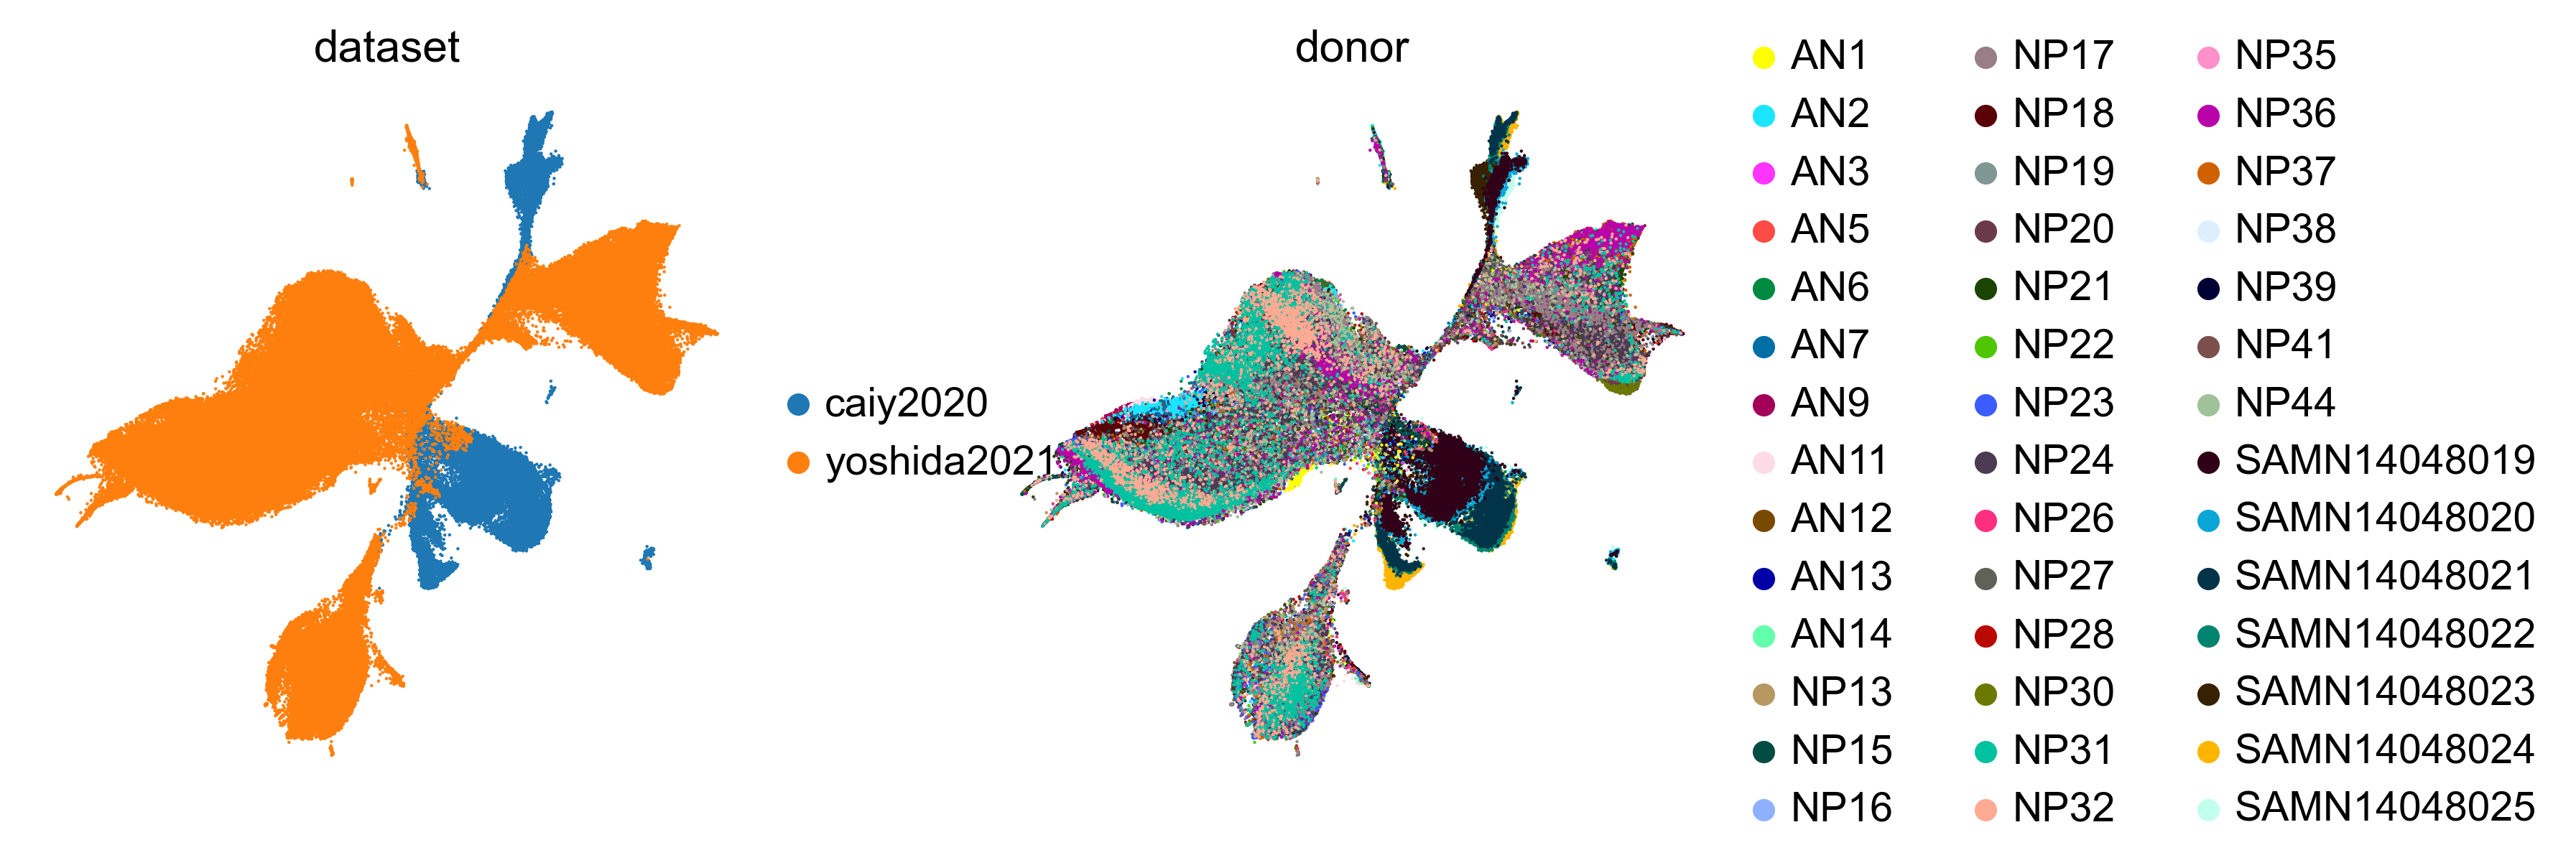

In [34]:
sc.pp.neighbors(adata_combined, n_neighbors=50, use_rep='X', random_state=30, metric = 'minkowski')
sc.tl.umap(adata_combined, min_dist = 0.3, spread = 1, random_state = 30)
sc.pl.umap(
    adata_combined,
    color=["dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


In [35]:
scvi.model.SCVI.setup_anndata(adata_combined, layer="counts", batch_key="donor")

In [36]:
vae = scvi.model.SCVI(adata_combined, n_layers=3, n_latent=50, gene_likelihood="nb", dispersion="gene-batch")

In [37]:
scvi.model.SCVI.view_anndata_setup(vae)

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'donor',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   42   │
│         n_cells          │ 246830 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor'] │     AN1      │          0          │
│                    │     AN2      │          1          │
│                    │     AN3      │          2          │
│                    │     AN5      │          3          │
│                    │     AN6      │          4          │
│                    │     AN7      │          5          │
│                    │     AN9      │          6          │
│                    │     AN11     │          7          │
│                    │     AN12     │          8          │
│                    │     AN13     │          9          │
│                    │     AN14     │         10          │
│                    │     NP13     │         11          │
│                    │     NP15     │         12          │
│                    │     NP16     │         13          │
│                    │     NP17     │         14          │
│                    │     NP18     │         15          │
│                    │     NP19     │         16          │
│                    │     NP20     │         17          │
│                    │     NP21     │         18          │
│                    │     NP22     │         19          │
│                    │     NP23     │         20          │
│                    │     NP24     │         21          │
│                    │     NP26     │         22          │
│                    │     NP27     │         23          │
│                    │     NP28     │         24          │
│                    │     NP30     │         25          │
│                    │     NP31     │         26          │
│                    │     NP32     │         27          │
│                    │     NP35     │         28          │
│                    │     NP36     │         29          │
│                    │     NP37     │         30          │
│                    │     NP38     │         31          │
│                    │     NP39     │         32          │
│                    │     NP41     │         33          │
│                    │     NP44     │         34          │
│                    │ SAMN14048019 │         35          │
│                    │ SAMN14048020 │         36          │
│                    │ SAMN14048021 │         37          │
│                    │ SAMN14048022 │         38          │
│                    │ SAMN14048023 │         39          │
│                    │ SAMN14048024 │         40          │
│                    │ SAMN14048025 │         41          │
└────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [38]:
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 32/32: 100%|██████████| 32/32 [36:39<00:00, 68.89s/it, loss=1.17e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=32` reached.


Epoch 32/32: 100%|██████████| 32/32 [36:39<00:00, 68.74s/it, loss=1.17e+03, v_num=1]


In [39]:
adata_combined.obsm["X_scVI"] = vae.get_latent_representation()

In [40]:
# Add random state command for neighbors and leiden

sc.pp.neighbors(adata_combined, n_neighbors=50, use_rep="X_scVI", random_state=30, metric = 'minkowski')
sc.tl.umap(adata_combined, min_dist = 0.3, spread = 1, random_state = 30)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:44)


In [41]:
plt.figure(figsize = (5, 5))


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

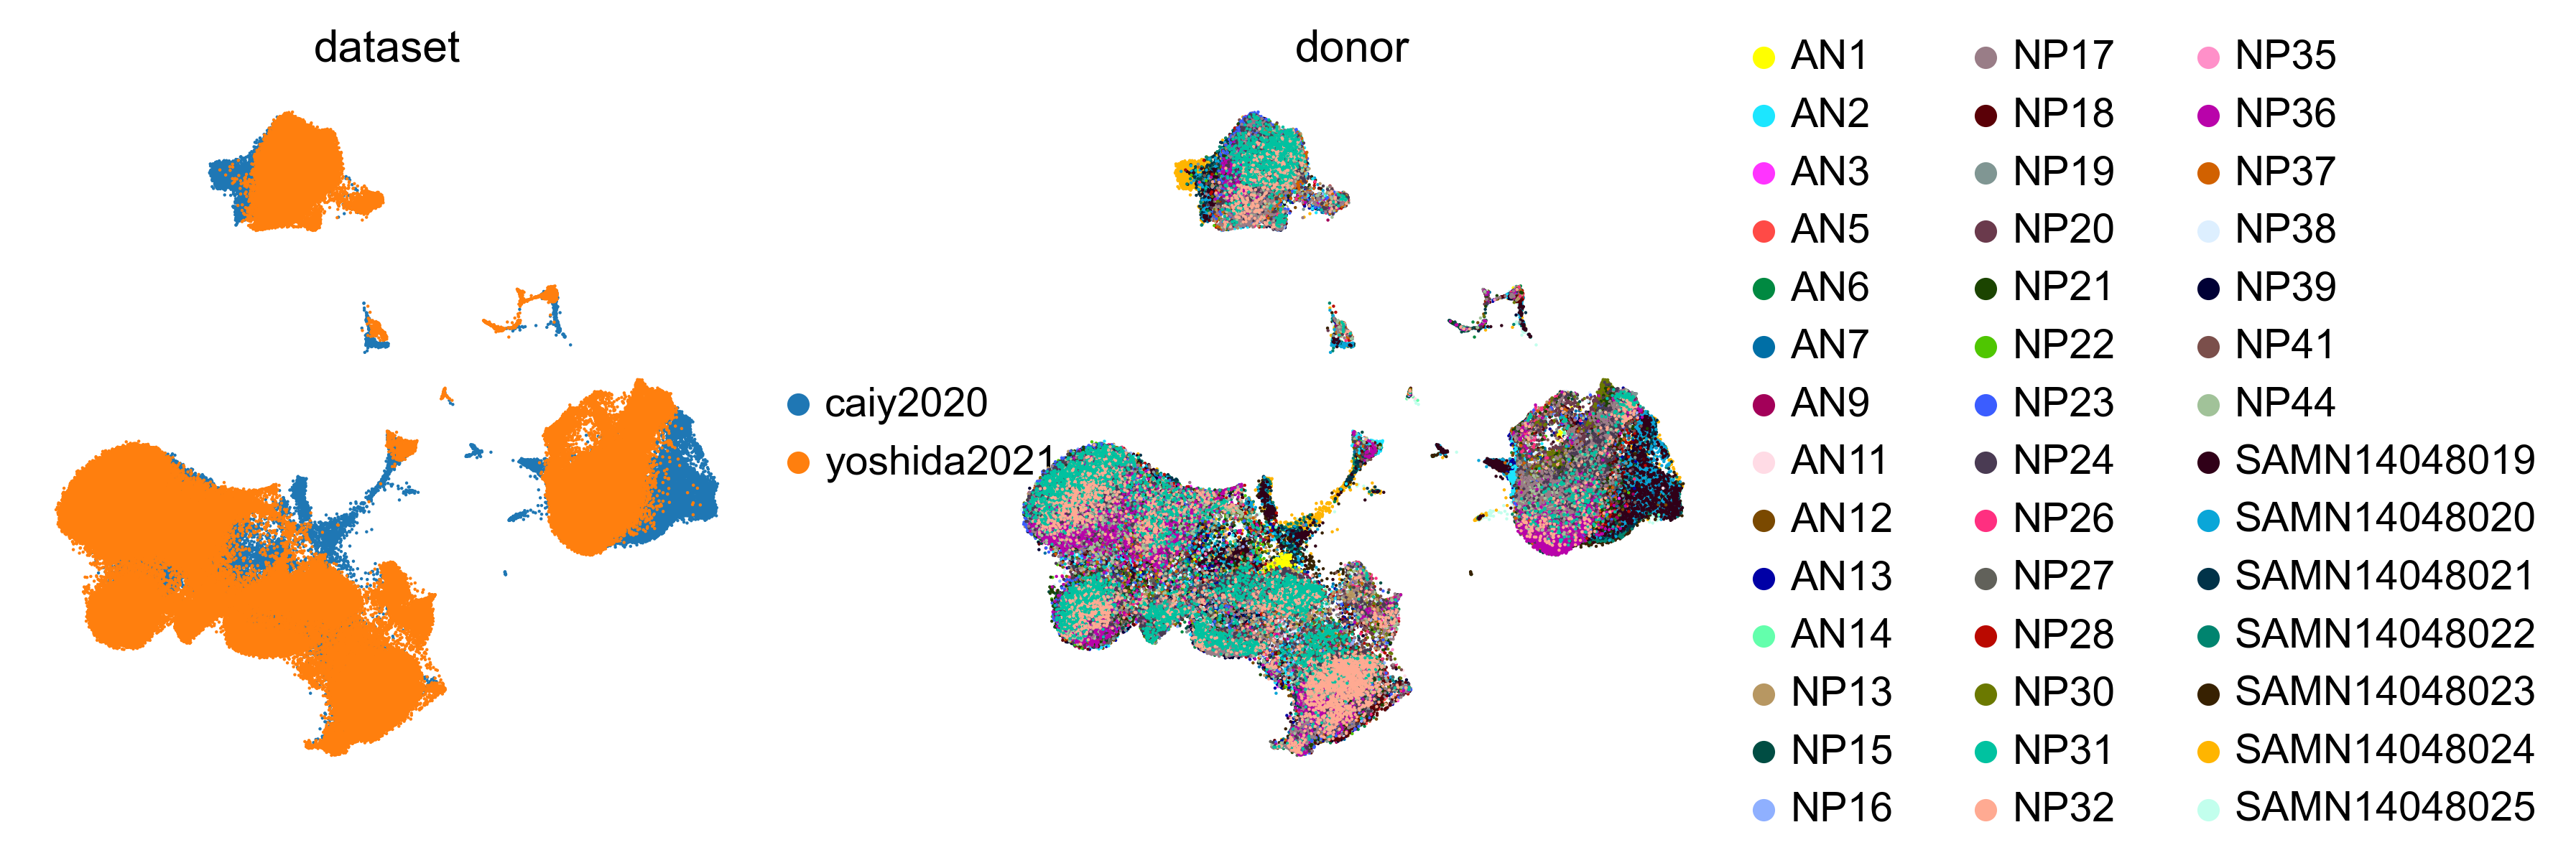

In [42]:
# Variables chosen as they are those shared by both datasets

sc.pl.umap(
    adata_combined,
    color=["dataset", "donor"],
    frameon=False,
    ncols=4,
    size=4
)


### SCCAF clustering analysis

In [43]:
import SCCAF as sccaf
from SCCAF import SCCAF_assessment, plot_roc

In [44]:
# Resolution on a scale from 0 to 1

sc.tl.leiden(adata_combined, resolution = 1.0, random_state = 1786)

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:03:48)


In [45]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata_combined.X, adata_combined.obs['leiden'], n = 100)

Mean CV accuracy: 0.8589
Accuracy on the training set: 1.0000
Accuracy on the hold-out set: 0.8117


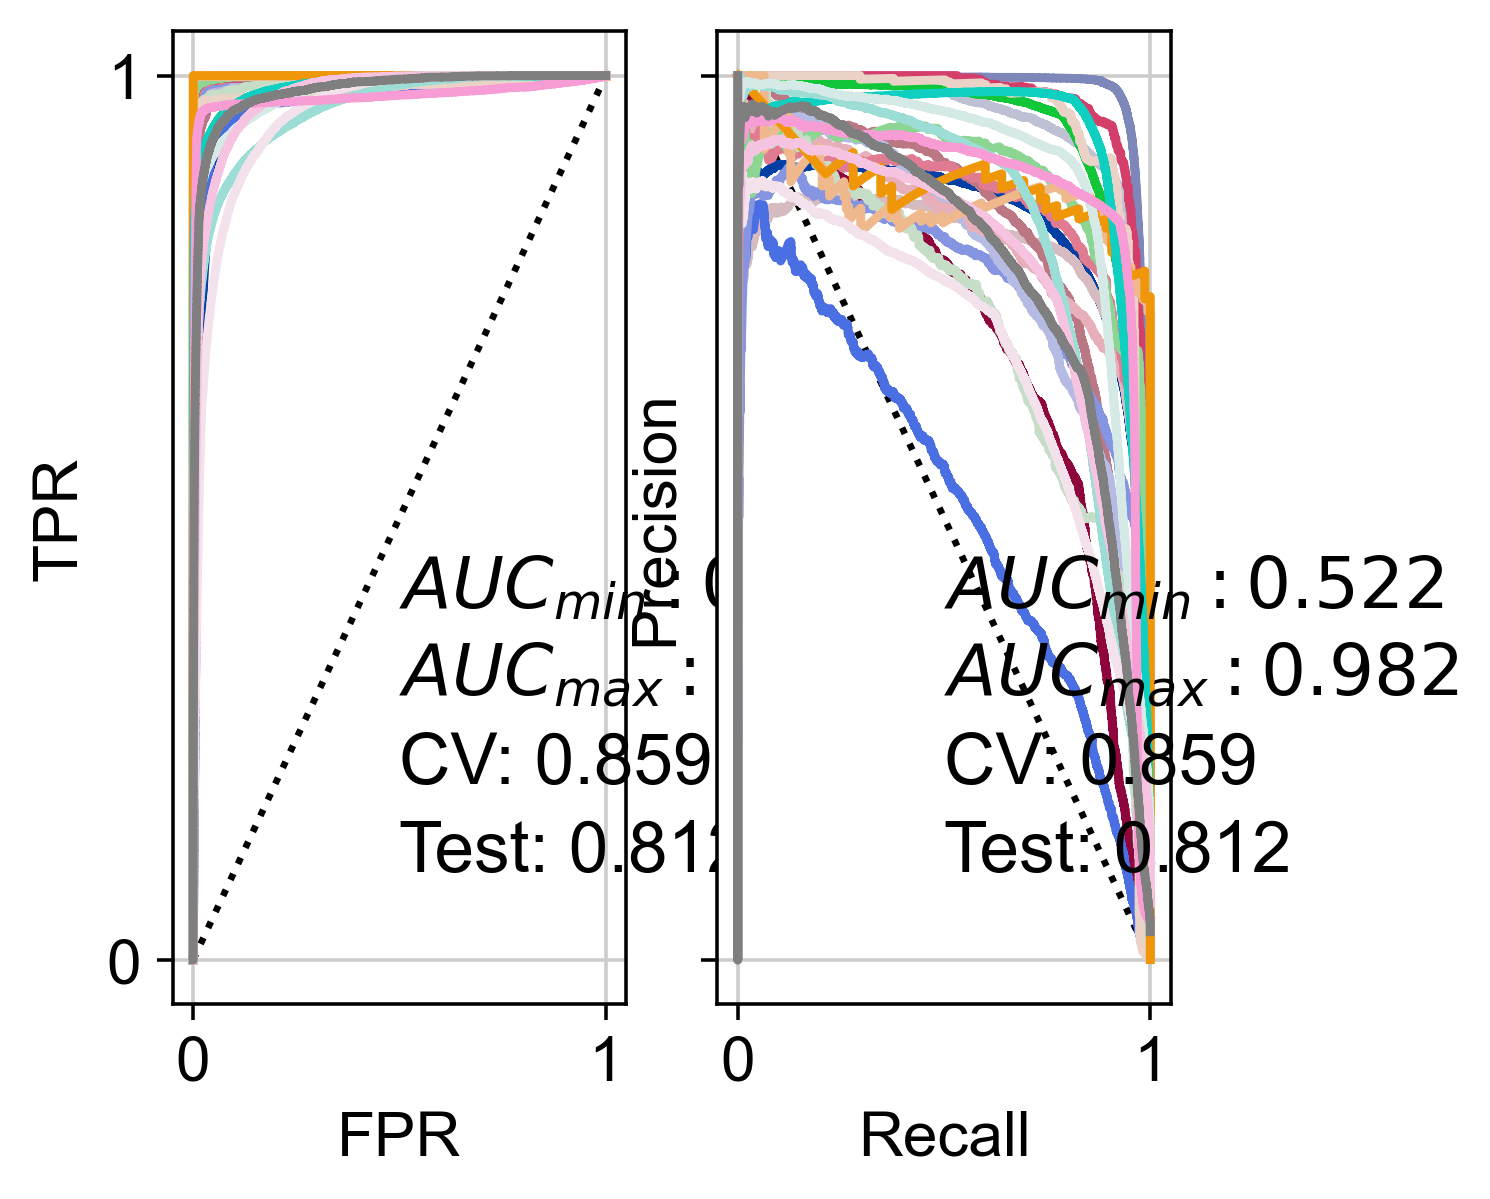

In [46]:
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)

plt.show()

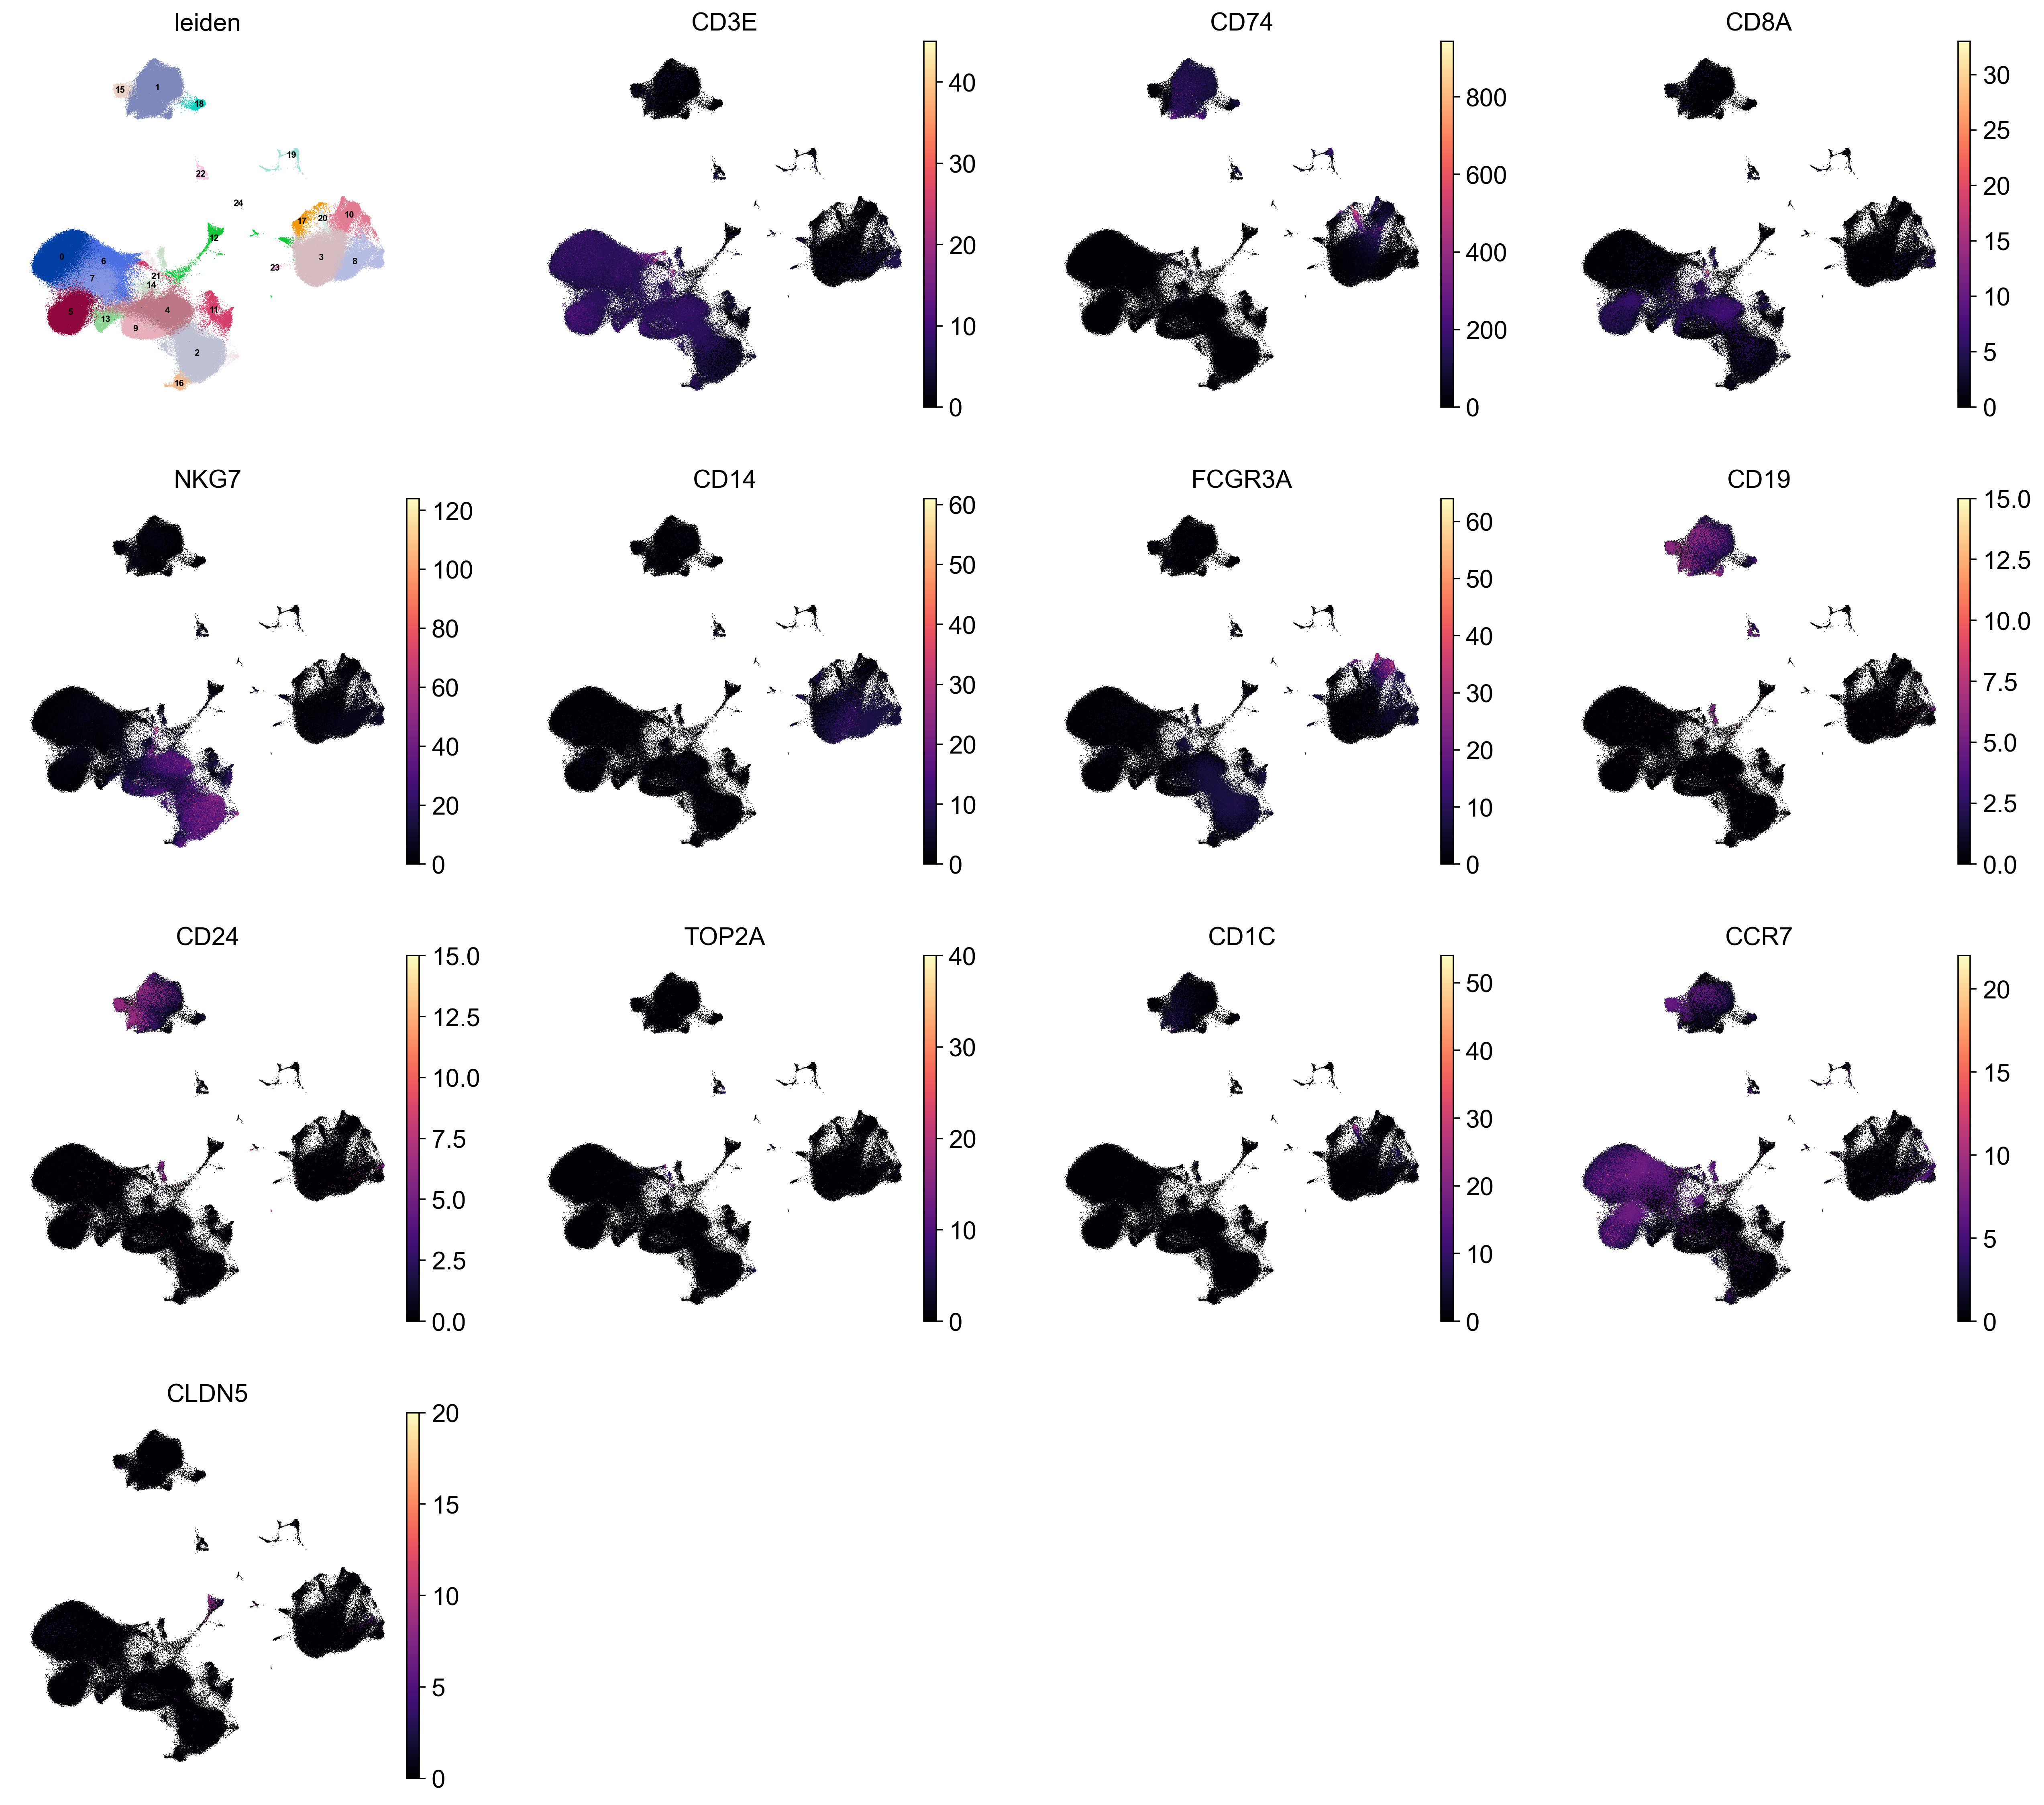

In [47]:
# Markers chosen here are of interest in healthy PBMCs

sc.pl.umap(adata_combined, frameon = False, color = ['leiden', 'CD3E', 'CD74', 'CD8A', 'NKG7', 'CD14', 'FCGR3A', 
                                                    'CD19',
                                                    'CD24',
                                                    'TOP2A',
                                                    'CD1C',
                                                    'CCR7',
                                                    'CLDN5'], 
                                                    size = 0.8, legend_fontsize = 5, legend_loc = 'on data', color_map="magma")


### Export clustered object

In [48]:
adata_raw


AnnData object with n_obs × n_vars = 246830 × 18966
    obs: 'study', 'tissue', 'donor', 'status', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'sample_id', 'dataset'
    var: 'gene_id-caiy2020', 'n_cells-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'hb-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021'

In [49]:
adata_combined

AnnData object with n_obs × n_vars = 246830 × 3000
    obs: 'study', 'tissue', 'donor', 'status', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'sample_id', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id-caiy2020', 'n_cells-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'hb-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'neighbors', 'umap', 'dataset_colors', 'donor_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors'
    obsm: 'X_umap', 'X_scVI'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [50]:
# Making a hybrid anndata object using sections from both raw anndata object and the object used for the model
adata_export = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata_combined.obs, uns = adata_combined.uns, obsm = adata_combined.obsm, obsp = adata_combined.obsp)
adata_export

AnnData object with n_obs × n_vars = 246830 × 18966
    obs: 'study', 'tissue', 'donor', 'status', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'sample_id', 'dataset', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_id-caiy2020', 'n_cells-caiy2020', 'mt-caiy2020', 'ribo-caiy2020', 'hb-caiy2020', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'name-yoshida2021'
    uns: 'hvg', 'neighbors', 'umap', 'dataset_colors', 'donor_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors'
    obsm: 'X_umap', 'X_scVI'
    obsp: 'distances', 'connectivities'

In [51]:
adata_export.write('/Users/mairi.mcclean/example_data_lake/processed_files/scvi_integration/PBMC_TB/CaiY_Yoshida_TB_scRNA_PBMC_mm230509_scVI-clustered.raw.h5ad')


### scVI DE exploration

In [52]:
# one vs all, over all groups (Comparison group is cluster 0)
full_de_res = vae.differential_expression(groupby='leiden')
full_de_res.head()

DE...: 100%|██████████| 25/25 [01:57<00:00,  4.71s/it]


proba_de  proba_not_de  bayes_factor    scale1        scale2   
TMEM37      0.9842        0.0158      4.131819  0.000005  3.650812e-07  \
TRBV19      0.9782        0.0218      3.803804  0.000257  4.851709e-05   
TRBV5-1     0.9772        0.0228      3.757930  0.000415  5.236604e-05   
TRBV11-3    0.9766        0.0234      3.731341  0.000030  6.316058e-06   
MAP3K8      0.9764        0.0236      3.722625  0.000010  3.835817e-04   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1   
TMEM37             0.0   0.25  4.648717    4.628619  2.735260  ...   0.007849  \
TRBV19             0.0   0.25  4.593954    4.830300  5.507608  ...   0.349218   
TRBV5-1            0.0   0.25  4.723869    4.904605  4.831004  ...   0.580262   
TRBV11-3           0.0   0.25  5.595172    5.854778  5.635336  ...   0.036817   
MAP3K8             0.0   0.25 -4.450213   -4.903859  2.312400  ...   0.014225   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2   
TMEM37     0.000446               0.006903               0.000248  \
TRBV19     0.081254               0.056719               0.015996   
TRBV5-1    0.103984               0.074769               0.016896   
TRBV11-3   0.008913               0.012462               0.003234   
MAP3K8     0.636924               0.011864               0.247320   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05   
TMEM37                0.064580              0.002530            True  \
TRBV19                2.868605              0.608591            True   
TRBV5-1               4.582928              0.771734            True   
TRBV11-3              0.307554              0.067943            True   
MAP3K8                0.112901              3.871715            True   

          comparison  group1 group2  
TMEM37     0 vs Rest       0   Rest  
TRBV19     0 vs Rest       0   Rest  
TRBV5-1    0 vs Rest       0   Rest  
TRBV11-3   0 vs Rest       0   Rest  
MAP3K8     0 vs Rest       0   Rest  

[5 rows x 22 columns]